In [1]:
import wave
from scipy.signal import spectrogram
import soundfile as sf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy

In [2]:
data, samplerate = sf.read('/Users/GodSpeed/Documents/Courses/Machine Learning/Project/LibriSpeech/dev-clean/84/121123/84-121123-0004.flac')

In [6]:
print len(data)
print samplerate
f, t, Sxx = spectrogram(data, samplerate)
print "No. of sample frequencies: ", len(f) #len(signal.spectrogram(data)[0])
print "No. of time segmnets:", len(t)
print "Spectrogram length: ", len(Sxx)
print Sxx.shape
#data is in the form [frequencies[time]]
#print type(Sxx)
for i in range(len(t) -  1):
    print t[i+1] - t[i]

70400
16000
No. of sample frequencies:  129
No. of time segmnets: 314
Spectrogram length:  129
(129, 314)
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014
0.014


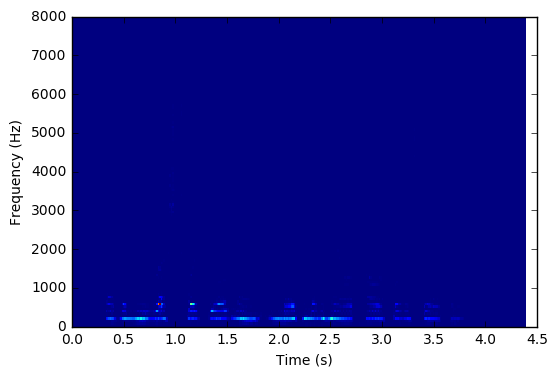

In [7]:
plt.pcolormesh(t,f,Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()
#print Sxx[:,313]

## Output labels

In [12]:
output_labels = {}
for i in range(26):
    output_labels[i] = chr(i+97)
output_labels[i+1] = ' '
output_labels

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: ' '}

### Initialize Theta

In [56]:
#set layer sizes
layers_sizes = [len(Sxx), 200, len(output_labels)]
input_size = len(Sxx)

"""this function is to initialize wi, 
weights from input layer to first hidden layer,
in the form [input layer[hidden layer]]"""
#arguments are no. of input features, size of first hidden layer
def initialize_wi(input_size, first_hidden_layer_size):
    e = np.sqrt(6)/np.sqrt(input_size + first_hidden_layer_size)
    wi = np.dot(np.random.rand(input_size + 1, 
                               first_hidden_layer_size), 2*e) - e
    return wi

"""this function is to initialize wh,
    weights from each hidden layer to next hidden layer
    creating wh array as [layer number[input layer[output layer]]]"""
def initialize_W_hh_next(hidden_layers_sizes):
    num_layers = len(hidden_layers_sizes)
    #return empty if only one hidden file
    if num_layers == 1:
        return
    wh = np.zeros((num_layers - 1, max(layers_sizes)+1, max(
                layers_sizes[1:len(layers_sizes)])+1))
    for i in range(num_layers):
        e = np.sqrt(6)/np.sqrt(hidden_layers_sizes[i]+hidden_layers_sizes[i+1])
        wh[i, 0:hidden_layers_sizes[i]+1, 0:hidden_layers_sizes[i+1]] = np.dot(
            np.random.rand((layers_sizes[i]+1), hidden_layers_sizes[i+1]),
            2*e)-e
    return wh

#initialize weights for recurrent neural network, hidden layer on itself
def initialize_W_hh_curr(layers_sizes):
    hidden_layers_sizes = layers_sizes[1:len(layers_sizes)-1]
    num_hidden_layers = len(hidden_layers_sizes)
    W_hh_curr = np.zeros((max(hidden_layers_sizes), num_hidden_layers))
    #for i in range(num_hidden_layers):
    #    e = np.sqrt(6)/np.sqrt(2*hidden_layers_sizes[i])
    #    W_hh_curr[0:hidden_layers_sizes[i], i] = np.dot(
    #        np.random.rand(hidden_layers_sizes[i]), 2*e)-e
    return W_hh_curr

#initialize weights from input to 1st hidden layer
wi = initialize_wi(layers_sizes[0], layers_sizes[1])

#initialize weights from each hidden layer to next hidden layer
wh_next = initialize_W_hh_next(layers_sizes[1:-1])
#print layers_sizes[1:-2]
print wh_next
#
W_hh_curr = initialize_W_hh_curr(layers_sizes)

#print wi.shape
#print W.shape
#print W_hh_curr.shape

None


In [ ]:
def sigmoid(z):

    # Local Variables: a, z
    # Function calls: exp, sigmoid
    a = 1.0/(1.0+np.exp((-z)))
    return a

def SGD_training(training_data, training_labels, validation_data, 
                 validation_labels, testing_data, testing_labels, LS, input_theta, delta_weight_prev, epochs):
    
    for i in range(training.size[1]):
        input_gate = sigmoid(input_that.transpose)

    # Local Variables: validation_error, samples_num, epochs, patience, validation_labels, error_min_index, RP, training_labels, all_layers_out, epoch, LS, theta, testing_images, accuracy, D, error_min_patience, learning_rate, error, batch_size, delta_weight_prev, Y, NL, a, validation_images, training_images, sample_set, i, break_point, num_of_labels, l, theta_best, testing_labels, training_error
    # Function calls: gca, rand, set, legend, num2str, figure, fwd_propagation, predict, title, sum, bwd_propagation, plot, ceil, forward_prop, ylabel, zeros, SGD_training, xlabel, Inf, validate, size
    #this function trains the neural network
    samples_num = training_data.size()
    NL = matcompat.size(LS, 2.)
    #%num of layers including input and output
    learning_rate = 0.1
    RP = 0.8
    #%regularization parameter
    #%Y = zeros(samples_num, LS(NL));
    patience = 150.
    #%number of epochs to skip for early stopping
    error_min_patience = Inf
    #%window_error = 0;   %error in the window to check improvement in validation
    num_of_labels = 10.
    D = np.zeros(num_of_labels, samples_num)
    #%D has desired response such that for any label, the bit for its index is 1
    #%in 10 digit binary vector D(sample_number,:) for that sample
    for l in np.arange(1., (num_of_labels-1.)+1):
        D[int(l)-1,:] = training_labels == l
        
    D[9,:] = training_labels == 0.
    #%epochs = 150;
    #%e = zeros(epochs,1);
    batch_size = 100.
    sample_set = np.zeros(batch_size, 1.)
    training_error = np.zeros(epochs, 1.)
    #%mean_training_error = zeros(epochs, 1);
    validation_error = np.zeros(epochs, 1.)
    #%mean_validation_error = zeros(epochs, 1);
    accuracy = np.zeros(epochs, 1.)
    for epoch in np.arange(1., (epochs)+1):
        for i in np.arange(1., (batch_size)+1):
            sample_set[int(i)-1,0] = np.ceil(np.dot(np.random.rand(1.), matcompat.size(training_images, 1.)))
            a = fwd_propagation(training_images[int(sample_set[int(i)-1])-1,:], theta, NL, LS).T
            #%changed a to form (units_in_layer by layer_number)
            [theta, delta_weight_prev] = bwd_propagation(a, theta, delta_weight_prev, D[:,int(sample_set[int(i)-1])-1], learning_rate, RP, NL, LS)
            
        #%error = 0;
        all_layers_out = forward_prop(training_images[int(sample_set)-1,:], theta, NL, LS)
        Y = all_layers_out[0:LS[int(NL)-1],:,int(NL)-1]
        error = (Y-D[:,int(sample_set)-1])**2.
        training_error[int(epoch)-1,0] = matdiv(np.sum(np.sum(error, 1.)), batch_size)
        validation_error[int(epoch)-1,0] = validate(theta, validation_images, validation_labels, NL, LS)
        accuracy[int(epoch)-1,0] = predict(theta, testing_images, testing_labels, NL, LS)
        if epoch >= patience:
            if validation_error[int(epoch)-1,0]<=error_min_patience:
                error_min_patience = validation_error[int(epoch)-1,0]
                error_min_index = epoch
                theta_best = theta
            
            
            if epoch > error_min_index+20.:
                #%taking window of 10 epochs
            break_point = epoch
            break
            #%window_error = sum(validation_error(error_min_index:epoch));
            #%else
            #%   window_mean = 
            
        
        
        break_point = epochs
        
    training_error = training_error[0:break_point]
    validation_error = validation_error[0:break_point]
    accuracy = accuracy[0:break_point]
    plt.figure()
    plt.plot(np.arange(1., (break_point)+1), validation_error, 'LineWidth', 1.5)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Square Error')
    plt.legend('Training Error', 'Validation Error')
    plt.title(np.array(np.hstack(('Performance for a batch size of ', num2str(batch_size)))))
    set(plt.gca, 'fontsize', 23.)
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy %')
    plt.title(np.array(np.hstack(('Accuracy percentage curve for batch size of ', num2str(batch_size)))))
    set(plt.gca, 'fontsize', 23.)
    return [training_error, validation_error, accuracy, theta_best, break_point]